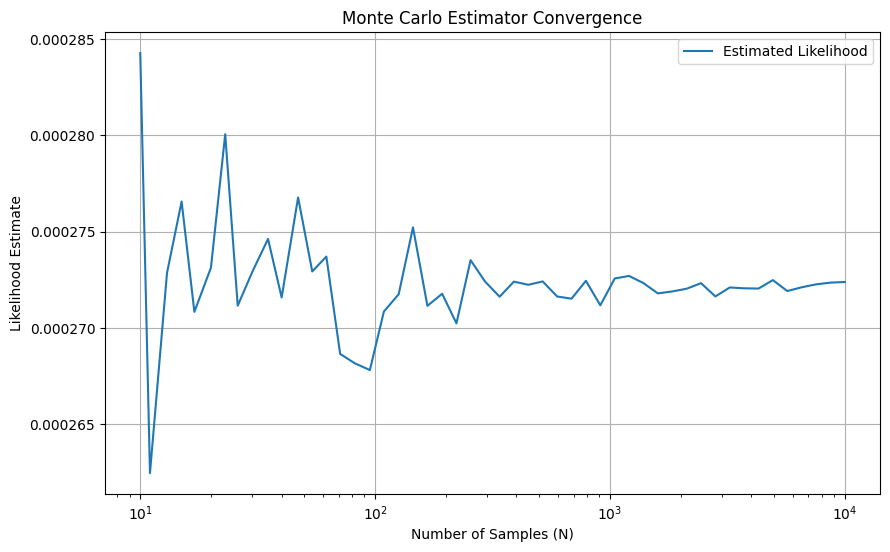

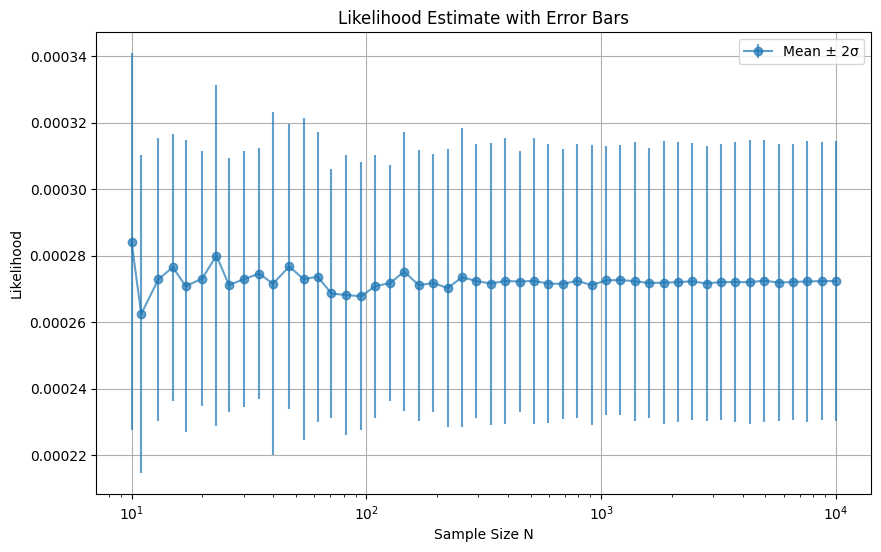

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson as simps

# Parameters
dt = 0.01                   # Time step
T = 3                       # Total time interval [0, 3]
X0 = 0                      # Initial trait value
theta = -0.5                # Drift coefficient (mean reversion)
sigma = 0.2                 # Diffusion coefficient (volatility)
lambda_base = 1             # Base speciation rate
lambda_slope = 0.3          # Trait dependence of speciation
mu = 0.2                    # Constant extinction rate

# Observed events
speciation_times = [1, 2]     # Speciations at t=1, t=2
extinction_time = 2.5         # One extinction at t=2.5

# Define tree structure: list of branches as (start_time, end_time)
branches = [
    (0.0, 1.0),     # A: root
    (1.0, 2.5),     # B: left child of A (dies at 2.5)
    (1.0, 2.0),     # C: right child of A
    (2.0, 3.0),     # D: left child of C
    (2.0, 3.0),     # E: right child of C
]

# Euler-Maruyama integration of the SDE for trait evolution
def simulate_trait_path(t_start, t_end):
    N_steps = int((t_end - t_start) / dt)
    t = np.linspace(t_start, t_end, N_steps + 1)
    X = np.zeros(N_steps + 1)
    X[0] = 0  # no random variation in starting trait

    for i in range(N_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i+1] = X[i] + theta * X[i] * dt + sigma * dW
    return t, X

# Compute likelihood for one simulation of all branches
def compute_likelihood():
    total_integral = 0
    lik_speciation = 1
    lik_extinction = 1

    for start, end in branches:
        t, X = simulate_trait_path(start, end)

        lambda_speciation = lambda_base + lambda_slope * X
        hazard = lambda_speciation + mu  # Total hazard per lineage

        # Integrate hazard over this branch
        integral = simps(hazard, t)
        total_integral += integral

        # If this branch ends in a speciation event, multiply by lambda_speciation at that time
        if end in speciation_times:
            idx = np.argmin(np.abs(t - end))
            lik_speciation *= lambda_speciation[idx]

        # If this branch ends in an extinction event, multiply by mu at that time
        if end == extinction_time:
            idx = np.argmin(np.abs(t - end))
            lik_extinction *= mu

    # Final likelihood
    likelihood = lik_speciation * lik_extinction * np.exp(-total_integral)
    return likelihood

# Monte Carlo estimation of the likelihood
def monte_carlo_estimator(N_samples):
    estimates = []
    for _ in range(N_samples):
        L = compute_likelihood()
        estimates.append(L)
    return np.mean(estimates), np.std(estimates)

# Run for increasing sample sizes to show convergence
Ns = np.logspace(1, 4, 50).astype(int)
means = []
stds = []

for N in Ns:
    mean_L, std_L = monte_carlo_estimator(N)
    means.append(mean_L)
    stds.append(std_L)

# Plotting convergence
plt.figure(figsize=(10,6))
plt.plot(Ns, means, label='Estimated Likelihood')
plt.xscale('log')
plt.xlabel('Number of Samples (N)')
plt.ylabel('Likelihood Estimate')
plt.title('Monte Carlo Estimator Convergence')
plt.grid(True)
plt.legend()
plt.show()

# Optional: plot error bars
plt.figure(figsize=(10,6))
plt.errorbar(Ns, means, yerr=2*np.array(stds), fmt='-o', label='Mean ± 2σ', alpha=0.7)
plt.xscale('log')
plt.xlabel('Sample Size N')
plt.ylabel('Likelihood')
plt.title('Likelihood Estimate with Error Bars')
plt.grid(True)
plt.legend()
plt.show()